<a href="https://colab.research.google.com/github/aliasgharchakera/GPU-Spring24-Assignment01/blob/main/AY06993_Assgn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-yuz0gynx
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-yuz0gynx
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 5cd225851b7638f3f6d55a19328295f16c014079
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.0.3-py3-none-any.whl size=7432 sha256=ad99cf1e6175f37f13398802e9e82d42885745e385f9d1c2ce678f3d359f3a95
  Stored in directory: /tmp/pip-ephem-wheel-cache-8rb50q7r/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Source files will be saved in "/tmp/tmpy7xz9beq".


In [3]:
!nvidia-smi

Sat Jan 27 05:14:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
%%cuda
#include <stdio.h>
#include <curand_kernel.h>

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}


__global__ void InitData(int* data)
{
    curandState_t state;
    curand_init(clock64(), 0, 0, &state);
    data[threadIdx.x] = curand(&state) % 100;
}

int main()
{
  const int N = 1000000;
  double time1, timedif;

  int* h_data = (int*)malloc(N * sizeof(int));
  int* d_data;

  time1 = (double) clock();            /* get initial time */
  for (int i = 0; i < N; i++)
    {
        h_data[i] = rand() % 100;
    }

  /* call clock a second time */
  timedif =  ((double) clock() - time1) / CLOCKS_PER_SEC;
  printf("The elapsed time is %lf seconds\n", timedif);

  //allocate memory on device
  cudaMalloc((void **)&d_data, N*sizeof(int));

  //call kernel
  time1 = (double) clock();
  InitData<<<1000,N/1000>>>(d_data);

  checkCudaErr(cudaDeviceSynchronize(), "Syncronization");
  timedif =  ((double) clock() - time1) / CLOCKS_PER_SEC;
  printf("The elapsed time is %lf seconds\n", timedif);
  checkCudaErr(cudaGetLastError(), "GPU Error");

  time1 = (double) clock();
  //copy device data to host memory
  checkCudaErr(cudaMemcpy(h_data, d_data, N*sizeof(int), cudaMemcpyDeviceToHost), "cudaMemcpy D->H");
  timedif =  ((double) clock() - time1) / CLOCKS_PER_SEC;
  printf("The elapsed time is %lf seconds\n", timedif);
  /*
  printf("Data (on device): \n");
  for(int i=0; i<N; ++i)
     printf(" data[%d] -> %d\n", i, h_data[i]);
  */
  //release GPU memory
  cudaFree(d_data);
  free(h_data);


  return 0;
}

The elapsed time is 0.019168 seconds
The elapsed time is 0.157717 seconds
The elapsed time is 0.000987 seconds



In [12]:
%%cuda
#include <stdio.h>
#include <time.h>

__global__ void sum(int* a, int* b, int* c, const int N) {
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    if (i<N) {
        c[i] = a[i] + b[i];
    }
}

void sum_host(int* a, int* b, int* c, const int N) {
    for (int i = 0; i < N; ++i) {
        c[i] = a[i] + b[i];
    }
}

int main() {
    int* h_a = 0;
    int* h_b = 0;
    int* h_c = 0;

    int* d_a = 0;
    int* d_b = 0;
    int* d_c = 0;

    const int sizes[] = {1000, 10000, 100000, 1000000}; // Different values of N
    const int numSizes = 4;
    double cpuTimes[numSizes];
    double gpuTimes[numSizes];

		// Open a file for writing
    FILE *f = fopen("timing_results.txt", "w");
    if (f == NULL) {
        printf("Error opening file!\n");
        return 1;
    }

		// Different execution configurations
    const int threadConfigs[] = {32, 64, 128, 256, 512};
    const int numConfigs = 5;

		for (int c = 0; c < numConfigs; ++c) {
      int numThreadsPerBlock = threadConfigs[c];

			for (int s = 0; s < numSizes; ++s) {
				const int N = sizes[s];
				int numBlocksPerGrid = ceilf(N/numThreadsPerBlock + 1);
				size_t size = N * sizeof(int);

				//allocate host memory
				h_a = (int*)malloc(size);
				h_b = (int*)malloc(size);
				h_c = (int*)malloc(size);

				//allocate device memory
				cudaMalloc((void**)&d_a, size);
				cudaMalloc((void**)&d_b, size);
				cudaMalloc((void**)&d_c, size);

				//calculate on host
				clock_t start = clock();
				sum_host(h_a, h_b, h_c, N);
				cpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

				//calculate on device
				start = clock();
				sum<<<numBlocksPerGrid, numThreadsPerBlock>>>(d_a, d_b, d_c, N);
				cudaDeviceSynchronize();
				gpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

				//copy result from device to host
				cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost);

				//delete data allocated on device
				cudaFree(d_a);
				cudaFree(d_b);
				cudaFree(d_c);

				//delete host memory
				free(h_a);
				free(h_b);
				free(h_c);

				// Write the results to the file
				fprintf(f, "%d\t%d\t%d\t%f\t%f\n", sizes[s], numThreadsPerBlock, numBlocksPerGrid, cpuTimes[s], gpuTimes[s]);
			}
		}

    // Close the file
    fclose(f);
    return 0;
}


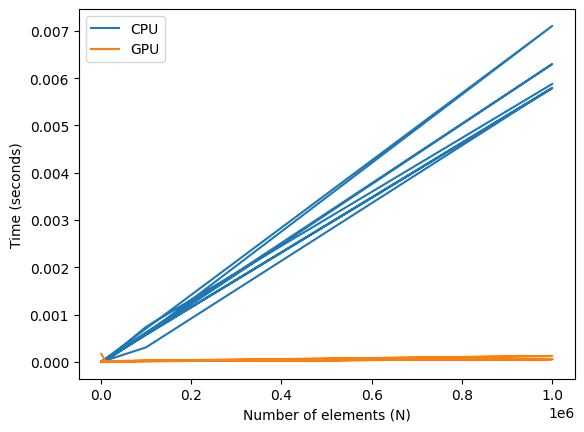

In [13]:
# prompt: use the results in timing_results and plot them using python

import matplotlib.pyplot as plt
import numpy as np

# Read the timing results from the file
with open('timing_results.txt') as f:
    data = f.readlines()

# Parse the data
sizes = []
thread_configs = []
num_blocks_per_grids = []
cpu_times = []
gpu_times = []
for line in data:
    line = line.strip()
    values = line.split('\t')
    sizes.append(int(values[0]))
    thread_configs.append(int(values[1]))
    num_blocks_per_grids.append(int(values[2]))
    cpu_times.append(float(values[3]))
    gpu_times.append(float(values[4]))

# Plot the CPU and GPU times
plt.plot(sizes, cpu_times, label='CPU')
plt.plot(sizes, gpu_times, label='GPU')
plt.xlabel('Number of elements (N)')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()
